In [1]:
%load_ext autoreload
%autoreload 2

import pyreadstat
import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Gallup data

In [2]:
# metadata on Gallup surveys
metadata = [['g201501', 2015, 1, np.nan],   # can't find immigration question in SPSS
            ['g201407', 2014, 6, 11],
            ['g201402', 2014, 2, 23],
            ['g201401', 2014, 1, np.nan],
            ['g201208', 2012, 6, 12],
            ['g201201', 2012, 1, np.nan],
            ['g201111', 2011, 6, 11],
            ['g201009', 2010, 7, 8],
            ['g200912', 2009, 7, 8],
            ['g200614', 2006, 4, 11],
            ['g200560', 2005, 12, 9],
            ['usaipocnus2002-34', 2002, 9, 16],
            ['a200140', 2001, 10, 3],
            ['g200113', 2001, 3, 6],
            ['g200039', 2000, 9, 6],
            ['aipo0713', 1965, 6, 13],
            ['31092366', 1964, 9, 16]]
metadata_df = pd.DataFrame(metadata, columns=['filename', 'year', 'month', 'imm_question'])

In [3]:
data_dir = '../gallup_data/'

all_dfs = []
imm_cols = []
num_obs = []
for _, row in metadata_df.iterrows():
    print(row['filename'])
    fn = os.path.join(data_dir, '%s.por' % row['filename'])
    df, meta = pyreadstat.read_por(fn)
    num_obs.append(len(df))
    
    # find column name for immigration question
    if np.isnan(row['imm_question']):
        imm_col = None
    elif 'Q%d' % row['imm_question'] in df.columns:
        imm_col = 'Q%d' % row['imm_question']
    elif 'Q0%d' % row['imm_question'] in df.columns:
        imm_col = 'Q0%d' % row['imm_question']
    else:
        imm_col = None
    
    if imm_col is None:
        print('Could not find Q for %s' % row['imm_question'])
        imm_cols.append(np.nan)
    else:
        imm_cols.append(imm_col)
        idx = list(df.columns).index(imm_col)
        print(meta.column_labels[idx])  # check that meta label makes sense
            
        d = {'filename': row['filename'], 'year': row['year'], 'month': row['month'],
             'imm_response':df[imm_col].values}
        for col in ['REGION', 'STATE', 'PARTY']:
            if col == 'STATE' and row['filename'] == 'aipo0713':
                d[col.lower()] = df['Q115'].values
            elif col == 'PARTY' and row['filename'] == '31092366':
                d[col.lower()] = df['Q47_PRTY'].values
            elif col in df.columns:
                d[col.lower()] = df[col].values
            else:
                d[col.lower()] = np.nan
                print('Could not find %s' % col) 
        columns = list(d.keys())
        new_df = pd.DataFrame(d, columns=columns)
        all_dfs.append(new_df)
    print()

df_concat = pd.concat(all_dfs)
metadata_df['imm_question'] = imm_cols
metadata_df['num_obs'] = num_obs

g201501
Could not find Q for nan

g201407
Immigration Levels Kept at Present Level, Increased or Decreased

g201402
Should Immigration Be Increased, Decreased or Kept at Present Level

g201401
Could not find Q for nan

g201208
View of U.S. Immigration Levels

g201201
Could not find Q for nan

g201111
Immigration Levels Increased or Decreased

g201009
Immigration Levels Increased or Decreased

g200912
Should Immigration Be Kept at Present Level, Increased or Decreased

g200614
View of Immigration Levels

g200560
View of Immigration Levels

usaipocnus2002-34
View on Immigration

a200140
Opinion on Immigration Levels

g200113
Immigration: Increased, Decresase or Kept at Present Level

g200039
In your view, should immigration be kept at its present level, increased or decreased?

aipo0713
SHOULD IMMIGRATION BE KEPT AT ITS PRESENT LEVEL, INCREASED, OR DECREASED?
Could not find REGION
Could not find PARTY

31092366
Number of immigrants allowed to enter US each year should be...



In [4]:
responses = ['present', 'increase', 'decrease']
percents = {r:[] for r in responses}
for (y, m), subdf in df_concat.groupby(['year', 'month']):
    for j, resp in enumerate(responses):
        percents[resp].append(np.sum(subdf.imm_response == (j+1)) / len(subdf))
for r in responses:
    print(r, np.mean(percents[r]))

present 0.3276753129830127
increase 0.15738005357129584
decrease 0.4195101915956299


In [5]:
metadata_df

,filename,year,month,imm_question,num_obs
0,g201501,2015,1,NaN,804
1,g201407,2014,6,Q11,1027
2,g201402,2014,2,Q23,1023
3,g201401,2014,1,NaN,1018
4,g201208,2012,6,Q12,1004
5,g201201,2012,1,NaN,1011
6,g201111,2011,6,Q11,1020
7,g201009,2010,7,Q8,1020
8,g200912,2009,7,Q08,1018
9,g200614,2006,4,Q11,1004


In [4]:
fn = os.path.join(data_dir, 'aipo0713.por')
df, meta = pyreadstat.read_por(fn)
for df_col, meta_col in zip(df.columns, meta.column_labels):
    if "state" in df_col.lower() or "state" in meta_col.lower():
        print(df_col, meta_col)

Q9A_1 RESTRICT TOTAL AMOUNT OF IMMIGRANTS (GEN.):  GUESS THEY ONLY LET IN A CERTAIN AMOUNT OF PEOPLE, PRESENT POLICY LIMITS NUMBER OF IMMIGRANTS...TELL ME ALL YOU KNOW ABOUT THE IMMIGRATION POLICY OF THE UNITED STATES?
Q9A_2 WE HAVE A QUOTA SYSTEM, ONLY SO MANY PEOPLE FROM EACH COUNTRY CAN COME IN, DEPENDS ON PERCENTAGE OF NATIONALITIES LIVING HERE...TELL ME ALL YOU KNOW ABOUT THE IMMIGRATION POLICY OF THE UNITED STATES?
Q9A_3 QUOTA SYSTEM FAVORS SOME GROUPS 'GIVES PREFERENCE TO WESTERN NATIONS AND THE ENGLISH SPEAKING PEOPLE'...TELL ME ALL YOU KNOW ABOUT THE IMMIGRATION POLICY OF THE UNITED STATES?
Q9A_4 RESPONDENT THINKS QUOTA SYSTEM UNFAIR:  IT SHOULD BE CHANGED, IT IS DISCRIMINATORY...TELL ME ALL YOU KNOW ABOUT THE IMMIGRATION POLICY OF THE UNITED STATES?
Q9A_5 SCREENING FOR QUALIFIED PEOPLE:  MUST HAVE A SPONSOR AND A JOB, MUST HAVE SKILL OR TRADE, MUST BE LITERATE, MUST PASS TESTS...TELL ME ALL YOU KNOW ABOUT THE IMMIGRATION POLICY OF THE UNITED STATES?
Q9A_6 SCREENING FOR UNDESI

In [5]:
fn = os.path.join(data_dir, 'aipo0713.por')
df, meta = pyreadstat.read_por(fn)
for df_col, meta_col in zip(df.columns, meta.column_labels):
    if "region" in df_col.lower() or "region" in meta_col.lower():
        print(df_col, meta_col)

In [7]:
fn = os.path.join(data_dir, 'aipo0713.por')
df, meta = pyreadstat.read_por(fn)
for df_col, meta_col in zip(df.columns, meta.column_labels):
    if "party" in df_col.lower() or "party" in meta_col.lower():
        print(df_col, meta_col)

Q102 IF THE ELECTIONS FOR CONGRESS WERE BEING HELD TODAY, WHICH PARTY WOULD YOU LIKE TO SEE WIN IN THIS CONGRESSIONAL DISTRICT OR DO YOU LEAN MORE TO THE REPUBLICAN PARTY OR MORE TO THE DEMOCRATIC PARTY?


In [8]:
fn = os.path.join(data_dir, '31092366.por')
df, meta = pyreadstat.read_por(fn)
for df_col, meta_col in zip(df.columns, meta.column_labels):
    if "party" in df_col.lower() or "party" in meta_col.lower():
        print(df_col, meta_col)

Q47_PRTY PartyID
Q48A Party your father usually voted for in presidential elections
Q48B Party your mother usually voted for in presidential elections
Q49AB For Congressional election, which party would you like to win/lean more to...


In [9]:
df['Q47_PRTY'].head(10)

0    4.0
1    4.0
2    4.0
3    1.0
4    4.0
5    4.0
6    2.0
7    4.0
8    2.0
9    4.0
Name: Q47_PRTY, dtype: float64

In [13]:
df_concat.head(10)

,filename,year,month,imm_response,region,state,party
0,g201407,2014,6,2.0,2.0,47.0,2.0
1,g201407,2014,6,1.0,2.0,32.0,4.0
2,g201407,2014,6,3.0,3.0,53.0,2.0
3,g201407,2014,6,3.0,3.0,54.0,1.0
4,g201407,2014,6,5.0,3.0,55.0,NaN
5,g201407,2014,6,3.0,2.0,33.0,1.0
6,g201407,2014,6,2.0,3.0,55.0,5.0
7,g201407,2014,6,1.0,1.0,14.0,4.0
8,g201407,2014,6,1.0,1.0,23.0,5.0
9,g201407,2014,6,5.0,1.0,23.0,2.0


In [14]:
df_concat.tail(10)

,filename,year,month,imm_response,region,state,party
1601,31092366,1964,9,3.0,5.0,52.0,1.0
1602,31092366,1964,9,2.0,5.0,52.0,4.0
1603,31092366,1964,9,4.0,5.0,52.0,4.0
1604,31092366,1964,9,3.0,5.0,52.0,4.0
1605,31092366,1964,9,3.0,5.0,52.0,4.0
1606,31092366,1964,9,4.0,5.0,52.0,4.0
1607,31092366,1964,9,2.0,5.0,52.0,2.0
1608,31092366,1964,9,2.0,5.0,52.0,4.0
1609,31092366,1964,9,2.0,5.0,52.0,4.0
1610,31092366,1964,9,2.0,5.0,52.0,4.0


In [15]:
df_concat.to_csv('../gallup_combined.csv', index=False)
metadata_df.to_csv('../gallup_metadata.csv', index=False)

In [10]:
response = {1.0:'present', 2.0:'increase', 3.0:'decrease'}

# TO DO: remake graphs from before, make sure concatenated data is correct
for key, subdf in df_concat.groupby(['year', 'month', 'region', 'imm_response']):
    if key[3] in response and key[0] >= 2000:
        print(key, len(subdf))

(2000, 9, 1.0, 1.0) 90
(2000, 9, 1.0, 2.0) 31
(2000, 9, 1.0, 3.0) 69
(2000, 9, 2.0, 1.0) 113
(2000, 9, 2.0, 2.0) 22
(2000, 9, 2.0, 3.0) 99
(2000, 9, 3.0, 1.0) 145
(2000, 9, 3.0, 2.0) 42
(2000, 9, 3.0, 3.0) 110
(2000, 9, 4.0, 1.0) 89
(2000, 9, 4.0, 2.0) 32
(2000, 9, 4.0, 3.0) 84
(2001, 3, 1.0, 1.0) 112
(2001, 3, 1.0, 2.0) 23
(2001, 3, 1.0, 3.0) 113
(2001, 3, 2.0, 1.0) 97
(2001, 3, 2.0, 2.0) 20
(2001, 3, 2.0, 3.0) 108
(2001, 3, 3.0, 1.0) 131
(2001, 3, 3.0, 2.0) 27
(2001, 3, 3.0, 3.0) 126
(2001, 3, 4.0, 1.0) 91
(2001, 3, 4.0, 2.0) 25
(2001, 3, 4.0, 3.0) 81
(2001, 10, 1.0, 1.0) 87
(2001, 10, 1.0, 2.0) 23
(2001, 10, 1.0, 3.0) 149
(2001, 10, 2.0, 1.0) 65
(2001, 10, 2.0, 2.0) 16
(2001, 10, 2.0, 3.0) 146
(2001, 10, 3.0, 1.0) 70
(2001, 10, 3.0, 2.0) 22
(2001, 10, 3.0, 3.0) 173
(2001, 10, 4.0, 1.0) 69
(2001, 10, 4.0, 2.0) 22
(2001, 10, 4.0, 3.0) 123
(2002, 9, 1.0, 1.0) 76
(2002, 9, 1.0, 2.0) 30
(2002, 9, 1.0, 3.0) 146
(2002, 9, 2.0, 1.0) 63
(2002, 9, 2.0, 2.0) 28
(2002, 9, 2.0, 3.0) 139
(2002, 9

In [6]:
data_dir = '../gallup_data/'
regions = ['northeast', 'midwest', 'south', 'west']
responses = ['present', 'increase', 'decrease']
new_df = []
for _, row in metadata_df.iterrows():
    if type(row['imm_question']) == str and row['year'] >= 2000:
        print(row['filename'])
        fn = os.path.join(data_dir, '%s.por' % row['filename'])
        df, meta = pyreadstat.read_por(fn)
        if 'REGION' in df.columns:
            d = {'filename':row['filename'], 'year':row['year'], 'month':row['month'], 'imm_question_col':row['imm_question']}
            for i, reg in enumerate(regions):
                subdf = df[df.REGION == (i+1)]
                d['%s_n' % reg] = len(subdf)
                imm_col = subdf[row['imm_question']]
                for j, resp in enumerate(responses):
                    d['%s_%s' % (reg, resp)] = len(subdf[imm_col == (j+1)])
            for i, party in zip([1, 5], ['republican', 'democrat']):
                subdf = df[df.PARTY == i]
                d['%s_n' % party] = len(subdf)
                imm_col = subdf[row['imm_question']]
                for j, resp in enumerate(responses):
                    d['%s_%s' % (party, resp)] = len(subdf[imm_col == (j+1)])
            new_df.append(d)
new_df = pd.DataFrame(new_df)
new_df

g201407
g201402
g201208
g201111
g201009
g200912
g200614
g200560
usaipocnus2002-34
a200140
g200113
g200039


,filename,year,month,imm_question_col,northeast_n,northeast_present,northeast_increase,northeast_decrease,midwest_n,midwest_present,...,west_increase,west_decrease,republican_n,republican_present,republican_increase,republican_decrease,democrat_n,democrat_present,democrat_increase,democrat_decrease
0,g201407,2014,6,Q11,202,83,45,68,225,74,...,54,94,298,96,43,150,267,99,81,76
1,g201402,2014,2,Q23,218,80,64,67,226,92,...,57,76,248,80,37,125,296,130,105,56
2,g201208,2012,6,Q12,230,110,46,65,228,100,...,38,71,314,131,44,131,315,165,67,71
3,g201111,2011,6,Q11,268,98,52,102,220,88,...,45,90,314,93,36,166,290,110,65,100
4,g201009,2010,7,Q8,221,83,35,93,240,74,...,43,85,293,94,32,157,292,111,63,110
5,g200912,2009,7,Q08,214,73,31,100,236,80,...,36,101,310,87,27,185,350,132,62,144
6,g200614,2006,4,Q11,220,76,37,94,233,98,...,33,102,326,114,42,160,344,130,60,142
7,g200560,2005,12,Q9,233,31,18,68,225,43,...,16,54,311,43,14,99,322,57,28,80
8,usaipocnus2002-34,2002,9,Q16,261,76,30,146,237,63,...,35,99,328,87,38,199,349,98,61,176
9,a200140,2001,10,Q3,269,87,23,149,236,65,...,22,123,341,94,18,220,327,94,37,181


In [7]:
datetimes = []
for y, m in zip(new_df.year, new_df.month):
    datetimes.append(datetime.datetime(year=y, month=m, day=1))

northeast
midwest
south
west


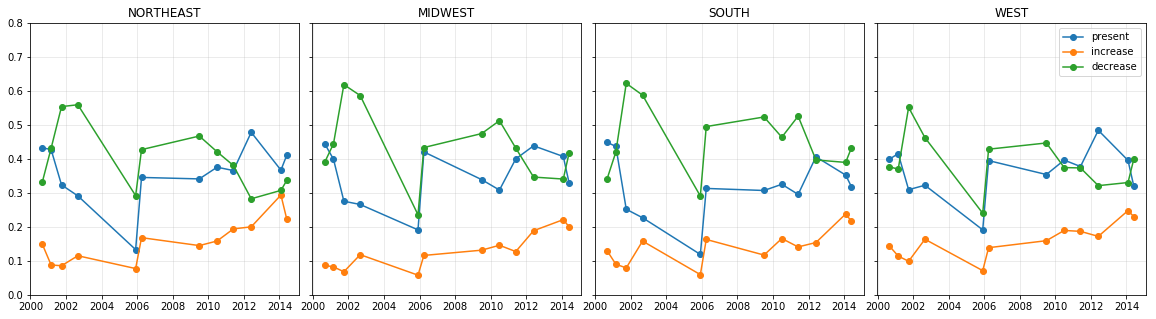

In [8]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
fig.subplots_adjust(wspace=0.05)
for reg, ax in zip(regions, axes):
    print(reg)
    ax.set_title(reg.upper())
    n = new_df['%s_n' % reg].values
    for resp in responses:
        counts = new_df['%s_%s' % (reg, resp)].values
        ax.plot_date(datetimes, counts / n, linestyle='-', label=resp)
    ax.set_ylim(0, 0.8)
    ax.grid(alpha=0.3)
    if reg == 'west':
        ax.legend()
plt.show()

republican
democrat


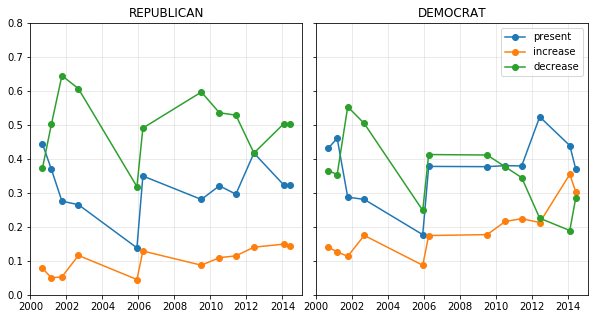

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
fig.subplots_adjust(wspace=0.05)
for party, ax in zip(['republican', 'democrat'], axes):
    print(party)
    ax.set_title(party.upper())
    n = new_df['%s_n' % party].values
    for resp in responses:
        counts = new_df['%s_%s' % (party, resp)].values
        ax.plot_date(datetimes, counts / n, linestyle='-', label=resp)
    ax.set_ylim(0, 0.8)
    ax.grid(alpha=0.3)
    if party == 'democrat':
        ax.legend()
plt.show()

present
increase
decrease


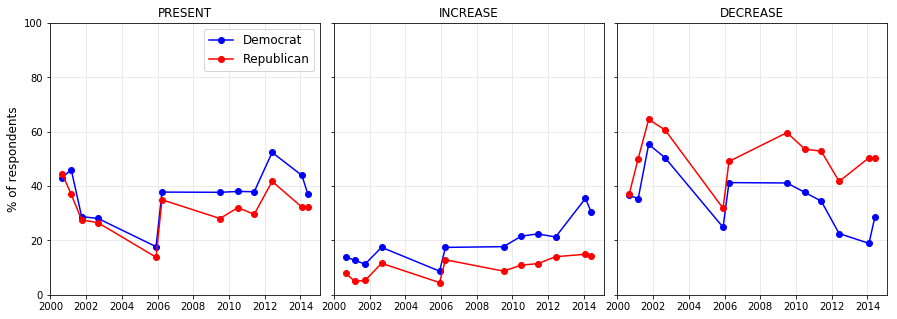

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.subplots_adjust(wspace=0.05)
colors = ['blue', 'red']
for resp, ax in zip(['present', 'increase', 'decrease'], axes):
    print(resp)
    ax.set_title(resp.upper())
    for party, c in zip(['democrat', 'republican'], colors):
        n = new_df['%s_n' % party].values
        counts = new_df['%s_%s' % (party, resp)].values
        ax.plot_date(datetimes, 100. * counts / n, linestyle='-', label=party.capitalize(), color=c)
    ax.set_ylim(0, 100)
    ax.grid(alpha=0.3)
    if resp == 'present':
        ax.legend(fontsize=12)
        ax.set_ylabel('% of respondents', fontsize=12)
plt.savefig('gallup_responses.pdf', bbox_inches='tight')
plt.show()

# Election year analysis

In [2]:
import statsmodels.api as sm

tone_df = pd.read_csv('../imm_speech_ids_with_tone_simple.tsv')
tone_df.head()

/dfs/scratch1/safegraph_homes/covid_mobility_venv/covid_mobility_venv/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/dfs/scratch1/safegraph_homes/covid_mobility_venv/covid_mobility_venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,speech_id,congress,date,imm_prob,keyword,chamber,party,state,speaker,speaker_id,pro_prob_sum,neutral_prob_sum,anti_prob_sum,tone_label,tone_label_int
0,0,430000211,43,18730306,0.995032,1,S,R,NV,Air. STEWART,43062621,0.000135,0.999743,0.000122,neutral,1
1,1,430000464,43,18730311,0.999902,1,S,R,MI,Mr. CHANDLER,43047031,0.000167,0.000286,0.999547,anti,0
2,2,430000796,43,18730314,0.998244,1,S,L,MO,Mr. SCLURZ,43040261,0.000154,0.999623,0.000223,neutral,1
3,3,430000904,43,18730318,0.999881,1,S,D,GA,Mr. NORWOOD,43053171,0.000149,0.999755,0.000096,neutral,1
4,4,430001178,43,18730320,0.990667,1,S,R,KS,Mr. CAcDWELL,43040911,0.000298,0.000144,0.999558,anti,0


In [3]:
tone_df.tail()

,Unnamed: 0,speech_id,congress,date,imm_prob,keyword,chamber,party,state,speaker,speaker_id,pro_prob_sum,neutral_prob_sum,anti_prob_sum,tone_label,tone_label_int
172885,172885,CREC-2020-12-28-pt1-PgE1211-4_0002,116,20201228,0.978863,1,H,D,CA,Mr. COSTA,C001059,0.999458,0.000440,0.000102,pro,2
172886,172886,CREC-2020-12-28-pt1-PgE1212_0003,116,20201228,0.993342,1,H,R,SC,Mr. WILSON of South Carolina,W000795,0.000124,0.001018,0.998858,anti,0
172887,172887,CREC-2020-12-28-pt1-PgE1207-3_0002,116,20201228,0.986257,0,H,D,NY,Mrs. CAROLYN B. MALONEY of New York,M000087,0.999735,0.000187,0.000079,pro,2
172888,172888,CREC-2020-12-29-pt1-PgS7958-2_0000,116,20201229,0.999783,1,S,D,MA,Mr. MARKEY,M000133,0.999740,0.000174,0.000086,pro,2
172889,172889,CREC-2020-12-29-pt1-PgS7961_0000,116,20201229,0.999784,1,S,R,OK,Mr. INHOFE,I000024,0.000175,0.000174,0.999652,anti,0


In [4]:
def get_num_months_to_next_election(month_int):
    month_dt = datetime.datetime.strptime(str(month_int), '%Y%m')
    if (month_dt.year % 2) == 0:  # even year
        if month_dt.month == 12:  # post-election
            next_election = datetime.datetime(month_dt.year+2, 11, 1)
        else:  # pre-election
            next_election = datetime.datetime(month_dt.year, 11, 1)
    else:  # odd year
        next_election = datetime.datetime(month_dt.year+1, 11, 1)
    return int((next_election - month_dt).days / 30)

In [5]:
tone_df['year'] = [int(d / 10000) for d in tone_df.date.values]
tone_df['month'] = [int(d / 100) for d in tone_df.date.values]
tone_df['num_months_left'] = tone_df.month.apply(lambda x: get_num_months_to_next_election(x))
tone_df.head()

,Unnamed: 0,speech_id,congress,date,imm_prob,keyword,chamber,party,state,speaker,speaker_id,pro_prob_sum,neutral_prob_sum,anti_prob_sum,tone_label,tone_label_int,year,month,num_months_left
0,0,430000211,43,18730306,0.995032,1,S,R,NV,Air. STEWART,43062621,0.000135,0.999743,0.000122,neutral,1,1873,187303,20
1,1,430000464,43,18730311,0.999902,1,S,R,MI,Mr. CHANDLER,43047031,0.000167,0.000286,0.999547,anti,0,1873,187303,20
2,2,430000796,43,18730314,0.998244,1,S,L,MO,Mr. SCLURZ,43040261,0.000154,0.999623,0.000223,neutral,1,1873,187303,20
3,3,430000904,43,18730318,0.999881,1,S,D,GA,Mr. NORWOOD,43053171,0.000149,0.999755,0.000096,neutral,1,1873,187303,20
4,4,430001178,43,18730320,0.990667,1,S,R,KS,Mr. CAcDWELL,43040911,0.000298,0.000144,0.999558,anti,0,1873,187303,20


In [69]:
tone_df.tail()

,Unnamed: 0,speech_id,congress,date,imm_prob,keyword,chamber,party,state,speaker,speaker_id,pro_prob_sum,neutral_prob_sum,anti_prob_sum,tone_label,tone_label_int,year,month,num_months_left
172885,172885,CREC-2020-12-28-pt1-PgE1211-4_0002,116,20201228,0.978863,1,H,D,CA,Mr. COSTA,C001059,0.999458,0.000440,0.000102,pro,2,2020,202012,23
172886,172886,CREC-2020-12-28-pt1-PgE1212_0003,116,20201228,0.993342,1,H,R,SC,Mr. WILSON of South Carolina,W000795,0.000124,0.001018,0.998858,anti,0,2020,202012,23
172887,172887,CREC-2020-12-28-pt1-PgE1207-3_0002,116,20201228,0.986257,0,H,D,NY,Mrs. CAROLYN B. MALONEY of New York,M000087,0.999735,0.000187,0.000079,pro,2,2020,202012,23
172888,172888,CREC-2020-12-29-pt1-PgS7958-2_0000,116,20201229,0.999783,1,S,D,MA,Mr. MARKEY,M000133,0.999740,0.000174,0.000086,pro,2,2020,202012,23
172889,172889,CREC-2020-12-29-pt1-PgS7961_0000,116,20201229,0.999784,1,S,R,OK,Mr. INHOFE,I000024,0.000175,0.000174,0.999652,anti,0,2020,202012,23


In [6]:
(np.array([1878, 1893]) / 10).astype(int)

array([187, 189])

In [29]:
def get_features_and_labels_for_party_year(tone_df, party, add_decade_fe=True):
    house_df = tone_df[(tone_df.party == party) & (tone_df.chamber == 'H')]
    print('Num speeches kept', len(house_df))
    X = []
    y = []
    years = []
    columns = ['pre-1980, even', 'pre-1980, odd', 'post-1980, even', 'post-1980, odd']
    for year, subdf in house_df.groupby(by='year'):
        if len(subdf) >= 10:
            x = np.zeros(4)
            if year < 1980:  # pre cable 
                if (year % 2) == 0:  # election year
                    x[0] = 1
                else:
                    x[1] = 1
            else:  # post cable 
                if (year % 2) == 0:
                    x[2] = 1
                else:
                    x[3] = 1                
            X.append(x)
            counts = subdf.tone_label.value_counts()
            percent_pro = counts['pro'] / len(subdf) if 'pro' in counts else 0
            percent_anti = counts['anti'] / len(subdf) if 'anti' in counts else 0
            score = 100. * (percent_pro - percent_anti)
            y.append(score)
            years.append(year)
    print('Num data points', len(X))
    
    if add_decade_fe:
        decades = (np.array(years) / 10).astype(int)
        decades = sorted(list(set(decades)))
        columns = columns + [str(d)+'0' for d in decades]
        decade2idx = {d:i for i,d in enumerate(decades)}
        decade_indices = [decade2idx[int(year / 10)] for year in years]
        decade_x = np.zeros((len(X), len(decades)))
        decade_x[np.arange(len(X)), decade_indices] = 1
        X = np.concatenate((X, decade_x), axis=1)
    X_df = pd.DataFrame(np.array(X), columns=columns)
    return X_df, np.array(y), np.array(years)

Num speeches kept 37335
Num data points 144
Num speeches kept 46255
Num data points 145


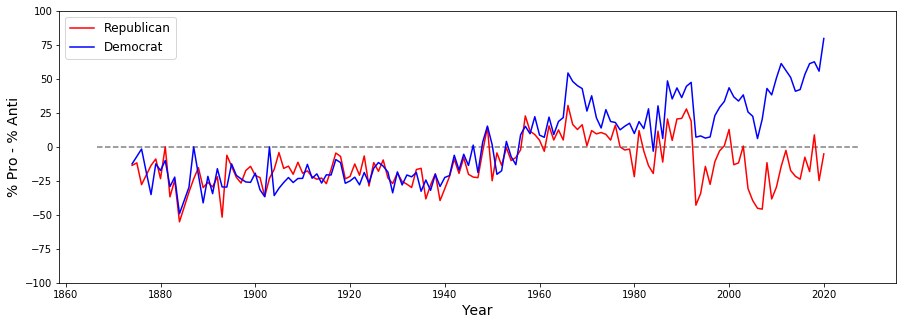

In [70]:
X_rep, y_rep, years_rep = get_features_and_labels_for_party_year(tone_df, 'R')
X_dem, y_dem, years_dem = get_features_and_labels_for_party_year(tone_df, 'D')

plt.figure(figsize=(15, 5))
plt.plot(years_rep, y_rep, color='red', label='Republican')
plt.plot(years_dem, y_dem, color='blue', label='Democrat')
plt.legend(fontsize=12)
plt.xlabel('Year', fontsize=14)
xmin, xmax = plt.xlim()
plt.hlines([0], xmin, xmax, color='grey', linestyle='dashed')
plt.ylim(-100, 100)
plt.ylabel('% Pro - % Anti', fontsize=14)
plt.show()

In [71]:
print(X_rep.values.shape)
print(years_rep[:10])
X_rep.head(10)

(144, 20)
[1874 1875 1876 1878 1879 1880 1881 1882 1883 1884]


,"pre-1980, even","pre-1980, odd","post-1980, even","post-1980, odd",1870,1880,1890,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010,2020
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


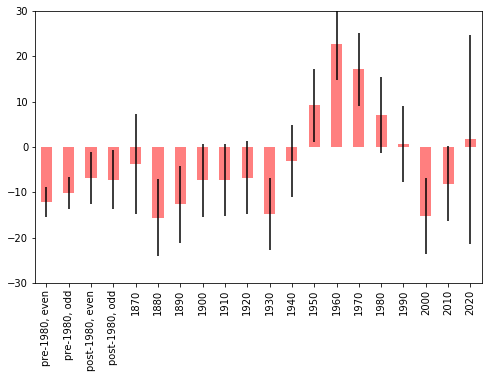

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     6.376
Date:                Tue, 03 May 2022   Prob (F-statistic):           1.34e-10
Time:                        16:50:49   Log-Likelihood:                -568.00
No. Observations:                 144   AIC:                             1172.
Df Residuals:                     126   BIC:                             1225.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
pre-1980, even    -12.1262      1.709     -7.097      0.000     -15.508      -8.745
pre-1980, odd     -10.2219      1.774     -5.763      0.000     -13.732      -6.712
post-1980, even    -6.7975      2.895     -2.348      0.020     -12.526      -1.069
post-1980, odd     -7.2410      3.306     -2.190      0.030     -13.783      -0.699
1870               -3.7675      5.617     -0.671      0.504     -14.883       7.348
1880              -15.5950      4.252     -3.667      0.000     -24.011      -7.180
1890              -12.7133      4.252     -2.990      0.003     -21.129      -4.298
1900               -7.3532      4.049     -1.816      0.072     -15.367       0.660
1910               -7.2680      4.049     -1.795      0.075     -15.281       0.745
1920               -6.7833      4.049     -1.675      0.096     -14.797       1.230
1930              -14.8194      4.049     -3.660      0.000     -22.833      -6.806
1940               -3.0939      4.049     -0.764      0.446     -11.107       4.919
1950                9.1768      4.049      2.266      0.025       1.163      17.190
1960               22.7666      4.049      5.622      0.000      14.753      30.780
1970               17.1022      4.049      4.224      0.000       9.089      25.116
1980                7.0221      4.236      1.658      0.100      -1.360      15.404
1990                0.5967      4.236      0.141      0.888      -7.786       8.979
2000              -15.2329      4.236     -3.596      0.000     -23.615      -6.851
2010               -8.0817      4.236     -1.908      0.059     -16.464       0.301
2020                1.6573     11.657      0.142      0.887     -21.411      24.725
==============================================================================
Omnibus:                        2.495   Durbin-Watson:                   1.657
Prob(Omnibus):                  0.287   Jarque-Bera (JB):                2.224
Skew:                           0.123   Prob(JB):                        0.329
Kurtosis:                       3.557   Cond. No.                     2.19e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.28e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [72]:
res = sm.OLS(y_rep, X_rep).fit()

err = res.params - res.conf_int()[0]
coef_df = pd.DataFrame({'coef':res.params.values, 'err':err.values, 'varname': err.index.values})
fig, ax = plt.subplots(figsize=(8,5))
coef_df.plot(x='varname', y='coef', kind='bar', ax=ax, yerr='err', color='red', alpha=0.5, legend=False)
ax.set_xlabel('')
ax.set_ylim(-30, 30)
plt.show()

res.summary()

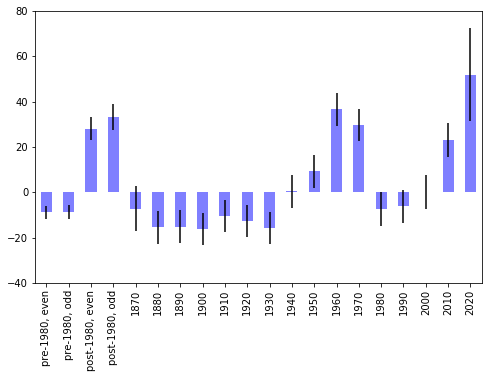

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     42.01
Date:                Tue, 03 May 2022   Prob (F-statistic):           8.35e-44
Time:                        16:52:01   Log-Likelihood:                -555.25
No. Observations:                 145   AIC:                             1146.
Df Residuals:                     127   BIC:                             1200.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
pre-1980, even     -8.9392      1.522     -5.874      0.000     -11.951      -5.928
pre-1980, odd      -8.6972      1.564     -5.560      0.000     -11.793      -5.602
post-1980, even    27.9484      2.578     10.840      0.000      22.846      33.051
post-1980, odd     33.2297      2.945     11.285      0.000      27.403      39.057
1870               -7.2377      5.003     -1.447      0.150     -17.137       2.661
1880              -15.5844      3.787     -4.115      0.000     -23.078      -8.091
1890              -15.1803      3.606     -4.210      0.000     -22.315      -8.046
1900              -16.3826      3.606     -4.544      0.000     -23.517      -9.248
1910              -10.6154      3.606     -2.944      0.004     -17.750      -3.481
1920              -12.6223      3.606     -3.501      0.001     -19.757      -5.488
1930              -15.8049      3.606     -4.384      0.000     -22.940      -8.670
1940                0.3553      3.606      0.099      0.922      -6.779       7.490
1950                9.1800      3.606      2.546      0.012       2.045      16.315
1960               36.5757      3.606     10.144      0.000      29.441      43.710
1970               29.6804      3.606      8.232      0.000      22.546      36.815
1980               -7.5563      3.773     -2.003      0.047     -15.022      -0.090
1990               -6.3005      3.773     -1.670      0.097     -13.767       1.166
2000                0.2488      3.773      0.066      0.948      -7.217       7.715
2010               22.9592      3.773      6.085      0.000      15.493      30.425
2020               51.8269     10.383      4.991      0.000      31.280      72.374
==============================================================================
Omnibus:                        0.718   Durbin-Watson:                   1.535
Prob(Omnibus):                  0.699   Jarque-Bera (JB):                0.838
Skew:                           0.148   Prob(JB):                        0.658
Kurtosis:                       2.775   Cond. No.                     2.39e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.08e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [73]:
res = sm.OLS(y_dem, X_dem).fit()

err = res.params - res.conf_int()[0]
coef_df = pd.DataFrame({'coef':res.params.values, 'err':err.values, 'varname': err.index.values})
fig, ax = plt.subplots(figsize=(8,5))
coef_df.plot(x='varname', y='coef', kind='bar', ax=ax, yerr='err', alpha=0.5, color='blue', legend=False)
ax.set_xlabel('')
ax.set_ylim(-40, 80)
plt.show()

res.summary()

In [57]:
def get_features_and_labels_for_party_month(tone_df, party, add_decade_fe=True):
    house_df = tone_df[(tone_df.party == party) & (tone_df.chamber == 'H')]
    print('Num speeches kept', len(house_df))
    X = []
    y = []
    months = []
    years = []
    columns = ['pre-1980, num months', 'post-1980, num months']
    for month, subdf in house_df.groupby(by='month'):
        if len(subdf) >= 10:
            year = subdf.iloc[0]['year']
            months_left = subdf.iloc[0]['num_months_left']
            x = np.zeros(2)
            if year < 1980:  # pre cable 
                x[0] = months_left + 1
            else:
                x[1] = months_left + 1
            X.append(x)
            month_dt = datetime.datetime.strptime(str(month), '%Y%m')
            months.append(month_dt)
            counts = subdf.tone_label.value_counts()
            percent_pro = counts['pro'] / len(subdf) if 'pro' in counts else 0
            percent_anti = counts['anti'] / len(subdf) if 'anti' in counts else 0
            score = 100. * (percent_pro - percent_anti)
            y.append(score)
            years.append(year)
    print('Num data points', len(X))
    
    if add_decade_fe:
        decades = (np.array(years) / 10).astype(int)
        decades = sorted(list(set(decades)))
        columns = columns + [str(d)+'0' for d in decades]
        decade2idx = {d:i for i,d in enumerate(decades)}
        decade_indices = [decade2idx[int(year / 10)] for year in years]
        decade_x = np.zeros((len(X), len(decades)))
        decade_x[np.arange(len(X)), decade_indices] = 1
        X = np.concatenate((X, decade_x), axis=1)
    X_df = pd.DataFrame(np.array(X), columns=columns)
    return X_df, np.array(y), np.array(months), np.array(years)

Num speeches kept 37335
Num data points 906
Num speeches kept 46255
Num data points 1008


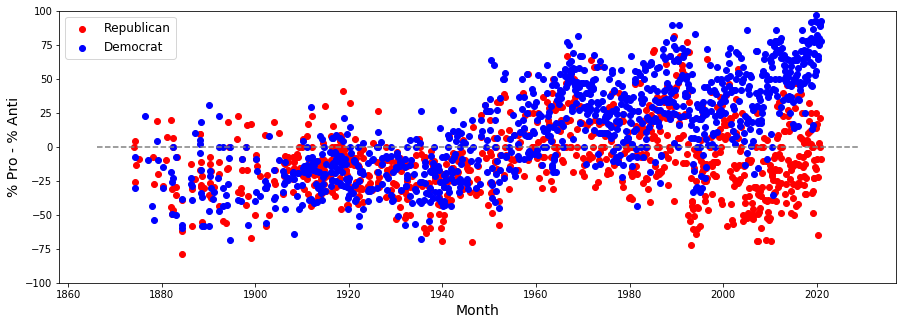

In [74]:
X_rep, y_rep, months_rep, years_rep = get_features_and_labels_for_party_month(tone_df, 'R')
X_dem, y_dem, months_dem, years_dem = get_features_and_labels_for_party_month(tone_df, 'D')

fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(months_rep, y_rep, color='red', label='Republican')
ax.scatter(months_dem, y_dem, color='blue', label='Democrat')
ax.set_xlabel('Month', fontsize=14)
plt.legend(fontsize=12)
xmin, xmax = plt.xlim()
ax.hlines([0], xmin, xmax, color='grey', linestyle='dashed')
ax.set_ylim(-100, 100)
ax.set_ylabel('% Pro - % Anti', fontsize=14)
plt.show()

In [75]:
print(X_rep.values.shape)
print(months_rep[:20])
X_rep.head(20)

(906, 18)
[datetime.datetime(1874, 1, 1, 0, 0) datetime.datetime(1874, 4, 1, 0, 0)
 datetime.datetime(1874, 5, 1, 0, 0) datetime.datetime(1874, 6, 1, 0, 0)
 datetime.datetime(1875, 2, 1, 0, 0) datetime.datetime(1878, 2, 1, 0, 0)
 datetime.datetime(1878, 6, 1, 0, 0) datetime.datetime(1879, 2, 1, 0, 0)
 datetime.datetime(1879, 4, 1, 0, 0) datetime.datetime(1880, 4, 1, 0, 0)
 datetime.datetime(1881, 1, 1, 0, 0) datetime.datetime(1881, 2, 1, 0, 0)
 datetime.datetime(1882, 1, 1, 0, 0) datetime.datetime(1882, 2, 1, 0, 0)
 datetime.datetime(1882, 3, 1, 0, 0) datetime.datetime(1882, 4, 1, 0, 0)
 datetime.datetime(1882, 5, 1, 0, 0) datetime.datetime(1882, 6, 1, 0, 0)
 datetime.datetime(1882, 7, 1, 0, 0) datetime.datetime(1883, 1, 1, 0, 0)]


,"pre-1980, num months","post-1980, num months",1870,1880,1890,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010,2020
0,11.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,22.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,10.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,22.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,8.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


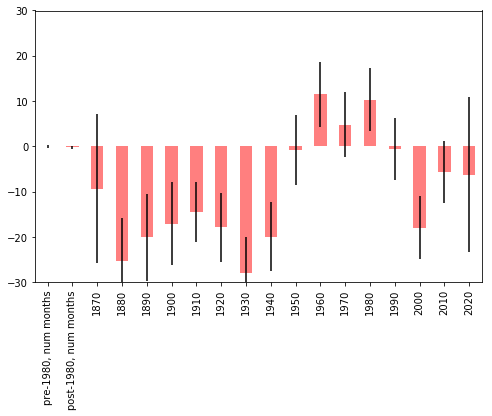

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     12.63
Date:                Tue, 03 May 2022   Prob (F-statistic):           4.75e-32
Time:                        16:52:42   Log-Likelihood:                -4167.1
No. Observations:                 906   AIC:                             8370.
Df Residuals:                     888   BIC:                             8457.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
pre-1980, num months      0.0354      0.164      0.216      0.829      -0.286       0.357
post-1980, num months    -0.1984      0.195     -1.018      0.309      -0.581       0.184
1870                     -9.3420      8.353     -1.118      0.264     -25.736       7.052
1880                    -25.3881      4.843     -5.242      0.000     -34.893     -15.883
1890                    -20.0890      4.849     -4.143      0.000     -29.606     -10.572
1900                    -17.0336      4.641     -3.670      0.000     -26.142      -7.925
1910                    -14.4932      3.424     -4.233      0.000     -21.213      -7.773
1920                    -17.8533      3.851     -4.636      0.000     -25.412     -10.295
1930                    -27.8887      4.053     -6.881      0.000     -35.843     -19.934
1940                    -19.9317      3.864     -5.158      0.000     -27.516     -12.347
1950                     -0.7299      3.923     -0.186      0.852      -8.429       6.969
1960                     11.4782      3.654      3.142      0.002       4.307      18.649
1970                      4.8287      3.698      1.306      0.192      -2.428      12.086
1980                     10.3177      3.519      2.932      0.003       3.412      17.224
1990                     -0.5483      3.495     -0.157      0.875      -7.408       6.311
2000                    -17.9810      3.528     -5.097      0.000     -24.905     -11.057
2010                     -5.5494      3.482     -1.594      0.111     -12.384       1.285
2020                     -6.2127      8.764     -0.709      0.479     -23.413      10.987
==============================================================================
Omnibus:                       20.996   Durbin-Watson:                   1.596
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.102
Skew:                           0.350   Prob(JB):                     1.59e-05
Kurtosis:                       3.307   Cond. No.                         120.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [76]:
res = sm.OLS(y_rep, X_rep).fit()

err = res.params - res.conf_int()[0]
coef_df = pd.DataFrame({'coef':res.params.values, 'err':err.values, 'varname': err.index.values})
fig, ax = plt.subplots(figsize=(8,5))
coef_df.plot(x='varname', y='coef', kind='bar', ax=ax, yerr='err', color='red', alpha=0.5, legend=False)
ax.set_xlabel('')
ax.set_ylim(-30, 30)
plt.show()

res.summary()

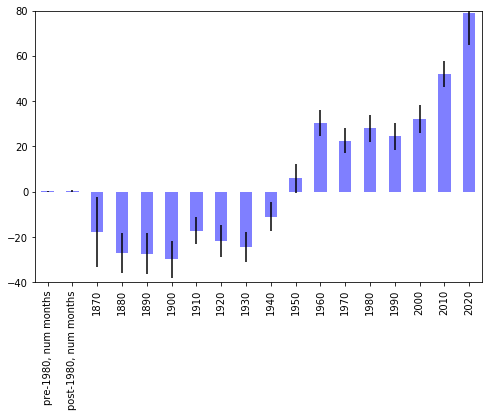

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     94.47
Date:                Tue, 03 May 2022   Prob (F-statistic):          1.94e-193
Time:                        16:56:52   Log-Likelihood:                -4531.2
No. Observations:                1008   AIC:                             9098.
Df Residuals:                     990   BIC:                             9187.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
pre-1980, num months      0.1450      0.139      1.040      0.298      -0.128       0.418
post-1980, num months     0.2889      0.167      1.728      0.084      -0.039       0.617
1870                    -17.7197      7.931     -2.234      0.026     -33.283      -2.156
1880                    -26.9063      4.486     -5.998      0.000     -35.710     -18.103
1890                    -27.3420      4.604     -5.939      0.000     -36.377     -18.307
1900                    -29.7972      4.152     -7.177      0.000     -37.944     -21.650
1910                    -17.2478      3.058     -5.641      0.000     -23.248     -11.247
1920                    -21.8220      3.570     -6.112      0.000     -28.828     -14.816
1930                    -24.3174      3.337     -7.288      0.000     -30.865     -17.770
1940                    -11.0952      3.278     -3.384      0.001     -17.529      -4.662
1950                      5.9577      3.291      1.811      0.071      -0.500      12.415
1960                     30.2436      2.916     10.370      0.000      24.521      35.967
1970                     22.5219      2.765      8.144      0.000      17.095      27.948
1980                     27.9333      3.007      9.290      0.000      22.033      33.834
1990                     24.4476      3.012      8.115      0.000      18.536      30.359
2000                     32.0008      3.137     10.201      0.000      25.845      38.157
2010                     51.9920      3.011     17.267      0.000      46.083      57.901
2020                     78.7951      7.039     11.194      0.000      64.982      92.608
==============================================================================
Omnibus:                        9.315   Durbin-Watson:                   1.694
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                9.309
Skew:                          -0.217   Prob(JB):                      0.00952
Kurtosis:                       3.184   Cond. No.                         131.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [77]:
res = sm.OLS(y_dem, X_dem).fit()

err = res.params - res.conf_int()[0]
coef_df = pd.DataFrame({'coef':res.params.values, 'err':err.values, 'varname': err.index.values})
fig, ax = plt.subplots(figsize=(8,5))
coef_df.plot(x='varname', y='coef', kind='bar', ax=ax, yerr='err', color='blue', alpha=0.5, legend=False)
ax.set_xlabel('')
ax.set_ylim(-40, 80)
plt.show()

res.summary()